<a href="https://colab.research.google.com/github/ManelSoengas/DL_Task2/blob/main/DL_task2_RobertTuito_15_8_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NO utilizamos/Utilizamos los datos aumentados mediante la técnica de swapping. Además la arquitectura contempla:


1.   Dropout y early_stopping
2.   Asignación de pesos en función del peso de la clase.
3.   La configuración y arquitectura se mantienen.
4.   Uso del modelo RoBERTuito para tweets en español.
5.   Preprocesado mínimo de los tweets.

https://huggingface.co/pysentimiento/robertuito-base-cased
https://medium.com/@dataproducts/text-preprocessing-techniques-in-natural-language-processing-19a840bb7a4f



# **Cargar los recursos necesarios.**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00


#**Cargar los datos de entrada**

In [2]:
from sklearn.utils import shuffle
# Cargar datos preprocesados
#train_data = pd.read_csv('/content/EXIST2021_training.tsv', delimiter=',', encoding='latin1')
#test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', delimiter=',', encoding='latin1')

import pandas as pd

# Leer los archivos TSV y seleccionar las columnas deseadas y filtrar por idioma 'es'
test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', sep='\t', usecols=['text', 'language', 'task2']).loc[lambda df: df['language'] == 'es']
train_data = pd.read_csv('/content/EXIST2021_training.tsv', sep='\t', usecols=['text', 'language', 'task2']).loc[lambda df: df['language'] == 'es']
#swapping data_set training
# Mezclar los datos de entrenamiento
shuffled_train_data = shuffle(train_data, random_state=42)

# Mezclar los datos de prueba
shuffled_test_data = shuffle(test_data, random_state=42)

# **Visualizar estructura de los datos**

In [ ]:
shuffled_train_data.head(10)

,language,text,task2
4148,es,"Janis Joplin, la 'perla' rebelde que cambió el...",non-sexist
3715,es,Diga lo que diga una amiga de verdad hubiera d...,non-sexist
4892,es,"me quiero follar al osito bimbo, sus deliciosa...",non-sexist
6941,es,Perra sensación solo dime que quieres que nos ...,objectification
5630,es,@SatoshiJimenez @lublo8 @elconfidencial @vox_e...,sexual-violence
5516,es,@javicmrs @tressymaniqui Aquí le explico en qu...,sexual-violence
6645,es,ME VOY A PEGAR UN TIRO PENSANDO EN QUIÉN ES EL...,misogyny-non-sexual-violence
5224,es,"soy super Dino, no me hablen chica/os alejense...",non-sexist
3914,es,"""No se merece mi poder divino Mejor no lo aviv...",non-sexist
4507,es,@nicetobezombie Camisa de manga corta y corbat...,non-sexist


# **Distribución de la clase objetivo**

In [3]:

columna_clase_objetivo = "task2"

df = shuffled_train_data

# Contar la cantidad de categorías únicas en la columna de la clase objetivo
cantidad_categorias = df[columna_clase_objetivo].nunique()

# Contar la cantidad de muestras para cada categoría de la clase objetivo
muestras_por_categoria = df[columna_clase_objetivo].value_counts()

# Imprimir los resultados
print("Cantidad de categorías:", cantidad_categorias)
print("Muestras por categoría:")
print(muestras_por_categoria)
df.shape[0]

Cantidad de categorías: 6
Muestras por categoría:
non-sexist                      1800
ideological-inequality           480
stereotyping-dominance           443
misogyny-non-sexual-violence     401
objectification                  244
sexual-violence                  173
Name: task2, dtype: int64


3541

# Preprocesado de los tweets.


---
1.  Anonimizar menciones, hastags y links.
2.  Convertir a minúsculas.
3.  Eliminar url que no utilizan http.
4.  Eliminar etiquetas html.
5.  Eliminar carácteres especiales.


In [4]:
import re

def anonimize_text(text):
    # Anonimizar nombres de usuario
    text = re.sub(r'@[\w_]+', '@user', text)

    # Anonimizar hashtags
    text = re.sub(r'#\w+', '#hashtag', text)

    # Anonimizar enlaces
    text = re.sub(r'https?://\S+', 'link', text)

    return text

shuffled_train_data['text_anonymized'] = shuffled_train_data['text'].apply(anonimize_text)
shuffled_test_data['text_anonymized'] = shuffled_test_data['text'].apply(anonimize_text)

In [5]:
# Convertir a minúsculas

shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.str.lower()
shuffled_train_data.head(10)
shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.str.lower()
shuffled_test_data.head(10)

,language,text,task2,text_anonymized
4287,es,En la rimas deberían respetar más a las mujere...,stereotyping-dominance,en la rimas deberían respetar más a las mujere...
2876,es,Yo te contemplaba como a una niña viendo Disne...,non-sexist,yo te contemplaba como a una niña viendo disne...
4281,es,-Se un lugar donde vas a estar a salvo- Dijo l...,non-sexist,-se un lugar donde vas a estar a salvo- dijo l...
3321,es,Así fue la liberación de Polonia por el Ejérci...,sexual-violence,así fue la liberación de polonia por el ejérci...
2996,es,Irene Montero comparte lecho con un señoro que...,misogyny-non-sexual-violence,irene montero comparte lecho con un señoro que...
3988,es,Eu segurando o choro quando o Chris canta “Vam...,non-sexist,eu segurando o choro quando o chris canta “vam...
3880,es,Es a nosotras a quienes están invisibilizando ...,non-sexist,es a nosotras a quienes están invisibilizando ...
3925,es,HIJOS DE REMIL PUTAS DEJEN DE MATARNOS!!!! htt...,misogyny-non-sexual-violence,hijos de remil putas dejen de matarnos!!!! link
3134,es,"@MarcosdeQuinto Te equivocas,la Nenaza mar y c...",stereotyping-dominance,"@user te equivocas,la nenaza mar y cona jamás ..."
4365,es,@alabadomango Cuéntame más!!Es por androcentri...,ideological-inequality,@user cuéntame más!!es por androcentrismo? tal...


In [6]:
# Eliminar url/website que no usan http, solo utilizan .com websites
# Palabras separadas por a . no son eliminadas

shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
shuffled_train_data.head(10)
shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
shuffled_test_data.head(10)

,language,text,task2,text_anonymized
4287,es,En la rimas deberían respetar más a las mujere...,stereotyping-dominance,en la rimas deberían respetar más a las mujere...
2876,es,Yo te contemplaba como a una niña viendo Disne...,non-sexist,yo te contemplaba como a una niña viendo disne...
4281,es,-Se un lugar donde vas a estar a salvo- Dijo l...,non-sexist,-se un lugar donde vas a estar a salvo- dijo l...
3321,es,Así fue la liberación de Polonia por el Ejérci...,sexual-violence,así fue la liberación de polonia por el ejérci...
2996,es,Irene Montero comparte lecho con un señoro que...,misogyny-non-sexual-violence,irene montero comparte lecho con un señoro que...
3988,es,Eu segurando o choro quando o Chris canta “Vam...,non-sexist,eu segurando o choro quando o chris canta “vam...
3880,es,Es a nosotras a quienes están invisibilizando ...,non-sexist,es a nosotras a quienes están invisibilizando ...
3925,es,HIJOS DE REMIL PUTAS DEJEN DE MATARNOS!!!! htt...,misogyny-non-sexual-violence,hijos de remil putas dejen de matarnos!!!! link
3134,es,"@MarcosdeQuinto Te equivocas,la Nenaza mar y c...",stereotyping-dominance,"@user te equivocas,la nenaza mar y cona jamás ..."
4365,es,@alabadomango Cuéntame más!!Es por androcentri...,ideological-inequality,@user cuéntame más!!es por androcentrismo? tal...


In [7]:
# Eliminar &text; etiquetas html

shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.apply(lambda x: re.sub(r'&[a-zñ]+;', '', x))
shuffled_train_data.head(10)
shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.apply(lambda x: re.sub(r'&[a-zñ]+;', '', x))
shuffled_test_data.head(10)

,language,text,task2,text_anonymized
4287,es,En la rimas deberían respetar más a las mujere...,stereotyping-dominance,en la rimas deberían respetar más a las mujere...
2876,es,Yo te contemplaba como a una niña viendo Disne...,non-sexist,yo te contemplaba como a una niña viendo disne...
4281,es,-Se un lugar donde vas a estar a salvo- Dijo l...,non-sexist,-se un lugar donde vas a estar a salvo- dijo l...
3321,es,Así fue la liberación de Polonia por el Ejérci...,sexual-violence,así fue la liberación de polonia por el ejérci...
2996,es,Irene Montero comparte lecho con un señoro que...,misogyny-non-sexual-violence,irene montero comparte lecho con un señoro que...
3988,es,Eu segurando o choro quando o Chris canta “Vam...,non-sexist,eu segurando o choro quando o chris canta “vam...
3880,es,Es a nosotras a quienes están invisibilizando ...,non-sexist,es a nosotras a quienes están invisibilizando ...
3925,es,HIJOS DE REMIL PUTAS DEJEN DE MATARNOS!!!! htt...,misogyny-non-sexual-violence,hijos de remil putas dejen de matarnos!!!! link
3134,es,"@MarcosdeQuinto Te equivocas,la Nenaza mar y c...",stereotyping-dominance,"@user te equivocas,la nenaza mar y cona jamás ..."
4365,es,@alabadomango Cuéntame más!!Es por androcentri...,ideological-inequality,@user cuéntame más!!es por androcentrismo? tal...


In [8]:
# Eliminar caráctres especiales, #:)(/\='] usados en emojis y hashtags

shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.str.replace("[^a-zA-ZñÑ#]", " ")
shuffled_train_data.head(10)
shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.str.replace("[^a-zA-ZñÑ#]", " ")
shuffled_test_data.head(10)

<ipython-input-8-2f10188dda66>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  shuffled_train_data.text_anonymized = shuffled_train_data.text_anonymized.str.replace("[^a-zA-ZñÑ#]", " ")
<ipython-input-8-2f10188dda66>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  shuffled_test_data.text_anonymized = shuffled_test_data.text_anonymized.str.replace("[^a-zA-ZñÑ#]", " ")


,language,text,task2,text_anonymized
4287,es,En la rimas deberían respetar más a las mujere...,stereotyping-dominance,en la rimas deber an respetar m s a las mujere...
2876,es,Yo te contemplaba como a una niña viendo Disne...,non-sexist,yo te contemplaba como a una niña viendo disne...
4281,es,-Se un lugar donde vas a estar a salvo- Dijo l...,non-sexist,se un lugar donde vas a estar a salvo dijo l...
3321,es,Así fue la liberación de Polonia por el Ejérci...,sexual-violence,as fue la liberaci n de polonia por el ej rci...
2996,es,Irene Montero comparte lecho con un señoro que...,misogyny-non-sexual-violence,irene montero comparte lecho con un señoro que...
3988,es,Eu segurando o choro quando o Chris canta “Vam...,non-sexist,eu segurando o choro quando o chris canta vam...
3880,es,Es a nosotras a quienes están invisibilizando ...,non-sexist,es a nosotras a quienes est n invisibilizando ...
3925,es,HIJOS DE REMIL PUTAS DEJEN DE MATARNOS!!!! htt...,misogyny-non-sexual-violence,hijos de remil putas dejen de matarnos link
3134,es,"@MarcosdeQuinto Te equivocas,la Nenaza mar y c...",stereotyping-dominance,user te equivocas la nenaza mar y cona jam s ...
4365,es,@alabadomango Cuéntame más!!Es por androcentri...,ideological-inequality,user cu ntame m s es por androcentrismo tal...


In [9]:
# Eliminar la columna 'text'
shuffled_train_data.drop('text', axis=1, inplace=True)
shuffled_test_data.drop('text', axis=1, inplace=True)
# Renombrar la columna 'text_anonimized' como 'text'
shuffled_train_data.rename(columns={'text_anonymized': 'text'}, inplace=True)
shuffled_train_data.head(10)
shuffled_test_data.rename(columns={'text_anonymized': 'text'}, inplace=True)
shuffled_test_data.head(10)

,language,task2,text
4287,es,stereotyping-dominance,en la rimas deber an respetar m s a las mujere...
2876,es,non-sexist,yo te contemplaba como a una niña viendo disne...
4281,es,non-sexist,se un lugar donde vas a estar a salvo dijo l...
3321,es,sexual-violence,as fue la liberaci n de polonia por el ej rci...
2996,es,misogyny-non-sexual-violence,irene montero comparte lecho con un señoro que...
3988,es,non-sexist,eu segurando o choro quando o chris canta vam...
3880,es,non-sexist,es a nosotras a quienes est n invisibilizando ...
3925,es,misogyny-non-sexual-violence,hijos de remil putas dejen de matarnos link
3134,es,stereotyping-dominance,user te equivocas la nenaza mar y cona jam s ...
4365,es,ideological-inequality,user cu ntame m s es por androcentrismo tal...


# **Carga de los recursos RoBERTuito**

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            truncation_strategy='longest_first',
            return_attention_mask=True

        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [11]:
def tokenize_robertuito(data, max_len=MAX_LEN):
  input_ids = []
  attention_masks = []

  for text in data:
    encoded = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=max_len,
      padding='max_length',
      truncation=True,
      return_attention_mask=True
    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids), np.array(attention_masks)

In [12]:

# Cargar el tokenizer de Robertuito

#tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("pysentimiento/robertuito-base-cased")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'RobertaTokenizerFast'.


# **Configuración**

In [10]:
MAX_LEN=255


In [13]:
X = shuffled_train_data['text'].values
y = shuffled_train_data['task2'].values
Z = shuffled_test_data['text'].values
z = shuffled_test_data['task2'].values

In [14]:
# Dividir los datos en entrenamiento y prueba
train_text, val_text, train_task2, val_task2 = train_test_split(X, y, test_size=0.2, random_state=42)

# **Codificación**

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

# Crear un objeto LabelEncoder para convertir las etiquetas de clase en valores numéricos
label_encoder = LabelEncoder()

# Ajustar el encoder con los datos de train_task2
label_encoder.fit(train_task2)

# Aplicar la transformación a los conjuntos de datos
train_task2_encoded = label_encoder.transform(train_task2)
val_task2_encoded = label_encoder.transform(val_task2)
z_encoded = label_encoder.transform(z)

# Ahora puedes usar train_task2_encoded, val_task2_encoded y z_encoded en tu modelo de clasificación

# Si deseas codificar las etiquetas de clase como one-hot encoded, utiliza OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Ajustar el encoder one-hot con las etiquetas codificadas numéricamente
onehot_encoder.fit(train_task2_encoded.reshape(-1, 1))

# Aplicar la transformación one-hot a los conjuntos de datos
train_task2_onehot = onehot_encoder.transform(train_task2_encoded.reshape(-1, 1))
val_task2_onehot = onehot_encoder.transform(val_task2_encoded.reshape(-1, 1))
z_onehot = onehot_encoder.transform(z_encoded.reshape(-1, 1))

# Ahora train_task2_onehot, val_task2_onehot y z_onehot contienen las etiquetas de clase codificadas como one-hot

Estoy utilizando **LabelBinarizer** de Scikit-Learn para convertir las etiquetas de clase en codificación one-hot. La principal diferencia aquí es que uso fit una vez para ajustar el codificador con las etiquetas de clase, y luego uso transform para convertir las etiquetas de cada conjunto de datos (entrenamiento, validación, prueba) en codificación one-hot. Esto asegura que las mismas transformaciones se apliquen a todas las etiquetas, lo que es importante para mantener la consistencia.



In [15]:
from sklearn.preprocessing import LabelBinarizer

etiquetas_clase = ["non-sexist", "ideological-inequality", "stereotyping-dominance", "misogyny-non-sexual-violence", "sexual-violence", "objectification"]

# Crear un objeto LabelBinarizer para convertir las etiquetas de clase en one-hot encoding
label_binarizer = LabelBinarizer()

# Ajustar el LabelBinarizer con las etiquetas de clase
label_binarizer.fit(etiquetas_clase)

# Transformar las etiquetas de clase en one-hot encoding
train_task2_onehot = label_binarizer.transform(train_task2)
val_task2_onehot = label_binarizer.transform(val_task2)
z_onehot = label_binarizer.transform(z)

In [ ]:
#import numpy as np
#train_input_ids, train_attention_masks = tokenize_roberta(train_text, MAX_LEN)
#val_input_ids, val_attention_masks = tokenize_roberta(val_text, MAX_LEN)
#test_input_ids, test_attention_masks = tokenize_roberta(Z, MAX_LEN)

In [16]:
# Utilizar el modelo Robertuito en lugar de RoBERTa
import numpy as np
train_input_ids, train_attention_masks = tokenize_robertuito(train_text, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_robertuito(val_text, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_robertuito(Z, MAX_LEN)

In [17]:
print(train_input_ids.shape)
print(val_input_ids.shape)
print(test_input_ids.shape)

(2832, 255)
(709, 255)
(2160, 255)


# **Cáculo y asignación de los pesos**

In [18]:
import numpy as np

# Frecuencias de las categorías
muestras_por_categoria = {
    "non-sexist": 1800,
    "ideological-inequality": 480,
    "stereotyping-dominance": 443,
    "misogyny-non-sexual-violence": 401,
    "sexual-violence": 173,
    "objectification": 244
}

total_muestras = sum(muestras_por_categoria.values())

# Calcular las frecuencias relativas
frecuencias_relativas = {cat: count / total_muestras for cat, count in muestras_por_categoria.items()}

# Calcular los pesos inversamente proporcionales a las frecuencias
pesos = {cat: 1 / freq for cat, freq in frecuencias_relativas.items()}

# Normalizar los pesos
suma_pesos = sum(pesos.values())
pesos_normalizados = {cat: weight / suma_pesos for cat, weight in pesos.items()}

print(pesos_normalizados)


{'non-sexist': 0.032171246846656336, 'ideological-inequality': 0.12064217567496127, 'stereotyping-dominance': 0.1307183844785133, 'misogyny-non-sexual-violence': 0.14440958684284638, 'sexual-violence': 0.33472973597677114, 'objectification': 0.23732887018025164}


In [19]:
import tensorflow as tf

# Crear el tensor de pesos para la función de pérdida
pesos_array = np.array(list(pesos_normalizados.values()))
pesos_tensor = tf.constant(pesos_array, dtype=tf.float32)

In [20]:
import tensorflow as tf

def create_multiclass_model(robertuito_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    #loss = tf.keras.losses.SparseCategoricalCrossentropy()
    #accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    #loss = tf.keras.losses.CategoricalCrossentropy()
    loss = weighted_categorical_crossentropy  # Utilizamos la función con pesos

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    output = robertuito_model([input_ids, attention_masks])
    output = output[1]

    # Agregar Dropout
    output = tf.keras.layers.Dropout(0.5)(output)

    # Cambiar la salida para clasificación multiclase (6 clases)
    output = tf.keras.layers.Dense(6, activation='softmax')(output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compilar el modelo
    # Cambiar la métrica de BinaryAccuracy a CategoricalAccuracy
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Compilar el modelo
    model.compile(opt, loss=loss, metrics=[accuracy])

    # Agregar Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')

    return model, early_stopping

    # Función de pérdida ponderada
#def weighted_categorical_crossentropy(y_true, y_pred):
    # Aplicar los pesos solo a las muestras positivas (las que tienen etiqueta 1)
    #weights = tf.reduce_sum(pesos_tensor * y_true, axis=1)
    #unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    #weighted_loss = unweighted_loss * weights
    #return tf.reduce_mean(weighted_loss)

    # Función de pérdida ponderada
def weighted_categorical_crossentropy(y_true, y_pred):
    # Convertir y_true a float32
    y_true = tf.cast(y_true, dtype=tf.float32)
    # Aplicar los pesos solo a las muestras positivas (las que tienen etiqueta 1)
    weights = tf.reduce_sum(pesos_tensor * y_true, axis=1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)



In [21]:
#roberta_model = TFRobertaModel.from_pretrained('roberta-base')
#robertuito_model = TFRobertuitoModel.from_pretrained("pysentimiento/robertuito-base-cased")
from transformers import TFRobertaModel

robertuito_model = TFRobertaModel.from_pretrained("pysentimiento/robertuito-base-cased", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [22]:
#model = create_model(roberta_model, MAX_LEN)
model, early_stopping = create_multiclass_model(robertuito_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 255)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  108787200  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 255,                                           

In [23]:
#history_2 = model.fit([train_input_ids,train_attention_masks], train_task2_onehot, validation_data=([val_input_ids,val_attention_masks], val_task2_onehot), epochs=8, batch_size=16)
history_2 = model.fit(
    [train_input_ids, train_attention_masks], train_task2_onehot,
    validation_data=([val_input_ids, val_attention_masks], val_task2_onehot),
    epochs=8,
    batch_size=32,
    callbacks=[early_stopping]  # Aquí se añade la devolución anticipada como callback
)

Epoch 1/8
89/89 [==============================] - 207s 2s/step - loss: 0.2178 - categorical_accuracy: 0.4283 - val_loss: 0.1839 - val_categorical_accuracy: 0.5205
Epoch 2/8
89/89 [==============================] - 149s 2s/step - loss: 0.1877 - categorical_accuracy: 0.4944 - val_loss: 0.1612 - val_categorical_accuracy: 0.5360
Epoch 3/8
89/89 [==============================] - 158s 2s/step - loss: 0.1540 - categorical_accuracy: 0.5561 - val_loss: 0.1439 - val_categorical_accuracy: 0.5642
Epoch 4/8
89/89 [==============================] - 158s 2s/step - loss: 0.1269 - categorical_accuracy: 0.6201 - val_loss: 0.1353 - val_categorical_accuracy: 0.5994
Epoch 5/8
89/89 [==============================] - 158s 2s/step - loss: 0.1045 - categorical_accuracy: 0.6751 - val_loss: 0.1321 - val_categorical_accuracy: 0.6093
Epoch 6/8
89/89 [==============================] - 158s 2s/step - loss: 0.0859 - categorical_accuracy: 0.7232 - val_loss: 0.1350 - val_categorical_accuracy: 0.6305
Epoch 7/8
89/89 

In [24]:
result_roberta = model.predict([test_input_ids,test_attention_masks])


68/68 [==============================] - 40s 527ms/step


In [25]:
# Evaluar el modelo
evaluation = model.evaluate([test_input_ids, test_attention_masks], z_onehot)

# Imprimir los resultados de la evaluación
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

68/68 [==============================] - 36s 532ms/step - loss: 0.1757 - categorical_accuracy: 0.6236
Loss: 0.17566688358783722
Accuracy: 0.6236110925674438


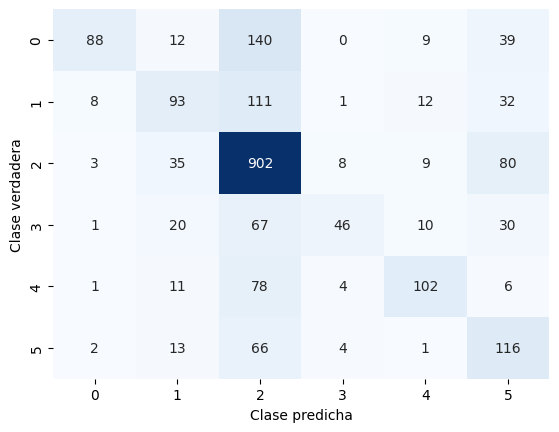

In [26]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que z_test.argmax(1) son las etiquetas reales y y_pred_roberta.argmax(1) son las etiquetas predichas
cm = confusion_matrix(z_onehot.argmax(1), y_pred_roberta.argmax(1))

# Crear un heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Añadir etiquetas a los ejes
plt.xlabel("Clase predicha")
plt.ylabel("Clase verdadera")

# Mostrar el gráfico
plt.show()

Se utiliza Robertutio para tweets en español. Los tweets se preprocesan, no se amplian datos y se utilizan pesos para compensar las clases minoritarias. learning_rate = 0.00001, batchsize= 16, epochs= 8.


#Resultados:
##Training:


```
Epoch 1/8
177/177 [==============================] - 242s 952ms/step - loss: 0.2130 - categorical_accuracy: 0.4421 - val_loss: 0.1713 - val_categorical_accuracy: 0.5275
Epoch 2/8
177/177 [==============================] - 160s 903ms/step - loss: 0.1679 - categorical_accuracy: 0.5286 - val_loss: 0.1421 - val_categorical_accuracy: 0.5726
Epoch 3/8
177/177 [==============================] - 160s 903ms/step - loss: 0.1281 - categorical_accuracy: 0.6123 - val_loss: 0.1299 - val_categorical_accuracy: 0.6079
Epoch 4/8
177/177 [==============================] - 160s 903ms/step - loss: 0.1019 - categorical_accuracy: 0.6773 - val_loss: 0.1338 - val_categorical_accuracy: 0.6276
Epoch 5/8
177/177 [==============================] - 159s 901ms/step - loss: 0.0809 - categorical_accuracy: 0.7419 - val_loss: 0.1311 - val_categorical_accuracy: 0.6714
```
##Evaluación:



```
68/68 [==============================] - 36s 533ms/step - loss: 0.1611 - categorical_accuracy: 0.6412
Loss: 0.16108420491218567
Accuracy: 0.6412037014961243

```






Se utiliza Robertutio para tweets en español. Los tweets se preprocesan, se amplian datos y se utilizan pesos para compensar las clases minoritarias. learning_rate = 0.00001, batchsize= 16, epochs= 8.

#Training:


```
Epoch 1/8
302/302 [==============================] - 347s 994ms/step - loss: 0.2037 - categorical_accuracy: 0.4578 - val_loss: 0.1443 - val_categorical_accuracy: 0.5840
Epoch 2/8
302/302 [==============================] - 283s 936ms/step - loss: 0.1428 - categorical_accuracy: 0.5882 - val_loss: 0.1068 - val_categorical_accuracy: 0.6708
Epoch 3/8
302/302 [==============================] - 282s 934ms/step - loss: 0.1022 - categorical_accuracy: 0.6790 - val_loss: 0.0903 - val_categorical_accuracy: 0.7304
Epoch 4/8
302/302 [==============================] - 282s 933ms/step - loss: 0.0766 - categorical_accuracy: 0.7510 - val_loss: 0.0799 - val_categorical_accuracy: 0.7750
Epoch 5/8
302/302 [==============================] - 282s 933ms/step - loss: 0.0569 - categorical_accuracy: 0.8057 - val_loss: 0.0806 - val_categorical_accuracy: 0.7907
Epoch 6/8
302/302 [==============================] - 262s 867ms/step - loss: 0.0382 - categorical_accuracy: 0.8599 - val_loss: 0.0834 - val_categorical_accuracy: 0.8023
```
#Evaluación:


```
68/68 [==============================] - 37s 536ms/step - loss: 0.2192 - categorical_accuracy: 0.6407
Loss: 0.21919400990009308
Accuracy: 0.6407407522201538
```




Se utiliza Robertutio para tweets en español. Los tweets se preprocesan, se amplian datos y se utilizan pesos para compensar las clases minoritarias. learning_rate = 0.00001, batchsize= 32, epochs= 8.

#Training:


```
Epoch 1/8
151/151 [==============================] - 325s 2s/step - loss: 0.2113 - categorical_accuracy: 0.4375 - val_loss: 0.1576 - val_categorical_accuracy: 0.5666
Epoch 2/8
151/151 [==============================] - 247s 2s/step - loss: 0.1569 - categorical_accuracy: 0.5459 - val_loss: 0.1182 - val_categorical_accuracy: 0.6303
Epoch 3/8
151/151 [==============================] - 248s 2s/step - loss: 0.1196 - categorical_accuracy: 0.6331 - val_loss: 0.0983 - val_categorical_accuracy: 0.7047
Epoch 4/8
151/151 [==============================] - 247s 2s/step - loss: 0.0934 - categorical_accuracy: 0.7059 - val_loss: 0.0883 - val_categorical_accuracy: 0.7411
Epoch 5/8
151/151 [==============================] - 247s 2s/step - loss: 0.0675 - categorical_accuracy: 0.7788 - val_loss: 0.0829 - val_categorical_accuracy: 0.7725
Epoch 6/8
151/151 [==============================] - 247s 2s/step - loss: 0.0503 - categorical_accuracy: 0.8280 - val_loss: 0.0781 - val_categorical_accuracy: 0.8073
Epoch 7/8
151/151 [==============================] - 247s 2s/step - loss: 0.0363 - categorical_accuracy: 0.8611 - val_loss: 0.0777 - val_categorical_accuracy: 0.8147
Epoch 8/8
151/151 [==============================] - 247s 2s/step - loss: 0.0253 - categorical_accuracy: 0.9002 - val_loss: 0.0794 - val_categorical_accuracy: 0.8288
```

#Evaluación:


```
68/68 [==============================] - 35s 520ms/step - loss: 0.2153 - categorical_accuracy: 0.6523
Loss: 0.21532265841960907
Accuracy: 0.6523148417472839
```



Se utiliza Robertutio para tweets en español. Los tweets se preprocesan, no se amplian datos y se utilizan pesos para compensar las clases minoritarias. learning_rate = 0.00001, batchsize= 32, epochs= 8.

#Training:


```
Epoch 1/8
89/89 [==============================] - 207s 2s/step - loss: 0.2178 - categorical_accuracy: 0.4283 - val_loss: 0.1839 - val_categorical_accuracy: 0.5205
Epoch 2/8
89/89 [==============================] - 149s 2s/step - loss: 0.1877 - categorical_accuracy: 0.4944 - val_loss: 0.1612 - val_categorical_accuracy: 0.5360
Epoch 3/8
89/89 [==============================] - 158s 2s/step - loss: 0.1540 - categorical_accuracy: 0.5561 - val_loss: 0.1439 - val_categorical_accuracy: 0.5642
Epoch 4/8
89/89 [==============================] - 158s 2s/step - loss: 0.1269 - categorical_accuracy: 0.6201 - val_loss: 0.1353 - val_categorical_accuracy: 0.5994
Epoch 5/8
89/89 [==============================] - 158s 2s/step - loss: 0.1045 - categorical_accuracy: 0.6751 - val_loss: 0.1321 - val_categorical_accuracy: 0.6093
Epoch 6/8
89/89 [==============================] - 158s 2s/step - loss: 0.0859 - categorical_accuracy: 0.7232 - val_loss: 0.1350 - val_categorical_accuracy: 0.6305
Epoch 7/8
89/89 [==============================] - 158s 2s/step - loss: 0.0717 - categorical_accuracy: 0.7691 - val_loss: 0.1361 - val_categorical_accuracy: 0.6333
```
#Evaluación:


```
68/68 [==============================] - 36s 532ms/step - loss: 0.1757 - categorical_accuracy: 0.6236
Loss: 0.17566688358783722
Accuracy: 0.6236110925674438
```


